# Performance for a Generic Linear Programming Problem

```{custom_download_link} ./environment_MUDE_opt_book.yml
:text: "Environment"
:replace_default: "False"
```

```{custom_download_link} ./performance_generic_LP_stripped.ipynb
:replace_default: "True"
```

```{admonition} MUDE Exam Information
:class: tip, dropdown
The material in this section is provided to give you extra insight into the performance of optimization algorithms. This material is not part of the exam.
```

In this notebook, we use a generic linear programming (LP) problem to demonstrate some performance-related concepts.

```{note}
Gurobi cannot be loaded in this online book, so download this notebook to work on it with Gurobi locally installed. Instruction on how to do that are in the `README.md` and `PA_2_4_A_gurobilicious.ipynb` of week 2.4.
```


## Standard form

consider the formulation below.

$$
\begin{align}
  & min & c^T x\\
  & \text{subject to} & Ax = b \\
  &  & x \geq 0 \\
\end{align}
$$

where $x$ is an $n \times 1$ column vector of decision variables, $A$ is an $m \times n$ matrix representing the constraint coefficients, $c$ is an $n \times 1$ column vector of objective function coefficients, and $b$ is an $m \times 1$ column vector of right-hand side values for constraints.

Any linear programming problem can be written in the standard form shown above. There are tricks to transform maximization problems, inequality constraint, etc. to this standard form, but we will not discuss them here.

So far, we have shown you example problems with specific forms. However, it is good to discuss the standard LP form as well. Many solvers (including Gurobi) offer possibilities to model LP problems with matrix-friendly representations. This can provide advantages in computation times, modeling effort and (sometimes) coding effort.

Now consider the slightly adjusted version of the standard LP form:

$$
\begin{align}
  & min & c^T x\\
  & \text{subject to} & Ax \geq  b \\
  &  & x \geq 0 \\
\end{align}
$$

Let's create a model in Gurobi to see how it works. First we nedd to create some random numbers for $A$, $b$ and $c$.

In [1]:
import numpy as np

m = 10
n = 5
c = np.random.randint(1, 5, n)
a = np.random.randint(1, 5, [m, n])
b = np.random.randint(1, 5, m)

a

array([[1, 4, 1, 1, 4],
       [4, 3, 2, 2, 3],
       [3, 2, 4, 4, 4],
       [3, 1, 4, 2, 3],
       [1, 1, 2, 2, 1],
       [1, 3, 4, 4, 1],
       [2, 3, 1, 3, 2],
       [2, 1, 4, 4, 3],
       [2, 4, 1, 3, 2],
       [4, 2, 4, 2, 4]])

 To create the model (based on what we have learned so far), you might do something like this:

In [2]:
import gurobipy as gp

# initiate the model
model = gp.Model()

# Create variables
x = model.addVars(len(c), name="x")

# Set objective
model.setObjective(gp.quicksum(c[i] * x[i] for i in range(len(c))), gp.GRB.MINIMIZE)

# Add constraints
for j in range(len(b)):
    model.addConstr(gp.quicksum(a[j, i] * x[i] for i in range(len(c))) >= b[j])

model.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-05-06


But another possibility is to use the matrix representation.

In [3]:
# initiate the model
model_matrix = gp.Model()

# Create variables
x = model_matrix.addMVar(shape=np.shape(c), name="x")

# Set objective
model_matrix.setObjective(c @ x, gp.GRB.MINIMIZE)

# Add constraints
model_matrix.addConstr(a @ x >= b, name="c")

model_matrix.update()

Now to make sure the two models are equivalent, we solve both and compare results.

Another way to compare the two models (which is only practical for small models) is printing the models and comparing the formulations (e.g., print(model.display())) but we go with comparing the results here.

In [4]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 5 columns and 50 nonzeros
Model fingerprint: 0x9cf49f51
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve time: 0.00s
Presolved: 10 rows, 5 columns, 50 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.600000e+01   0.000000e+00      0s
       3    3.3333333e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.333333333e+00


In [5]:
model_matrix.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 5 columns and 50 nonzeros
Model fingerprint: 0x9cf49f51
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve time: 0.02s
Presolved: 10 rows, 5 columns, 50 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.600000e+01   0.000000e+00      0s
       3    3.3333333e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.333333333e+00


In [6]:
model.ObjVal == model_matrix.ObjVal

True

You can easily formulate most LP problems with the matrix representation. But apart from the convenience of matrix representation (whenever possible), why should you use this form? To answer that question, we will do a small experiment together.

## Matrix modeling times v.s. loop modeling times

To set up our little computational experiment, we first need to define some functions to generate random input, construct the model and to solve it. Explanations are provided via comments inside the functions.


In [7]:
def model_input_lp(m, n, sparsity):

    np.random.seed(seed=1)
    c = np.random.randint(1, 10, n)
    a = np.random.randint(1, 10, [m, n])
    b = np.random.randint(1, 10, m)

    # set some elements of A matrix to zero (in practice, this matrix is often sparse)
    for column in range(n):
        zero_indices = np.random.choice(range(m), int(m*(1-sparsity)), replace=False)
        a[zero_indices, column] = 0

    return a, b, c

In [8]:
from datetime import datetime

def model_construct_lp_matrix(a, b, c):

    # to record execution time
    begin_time = datetime.now()

    # Create a new model
    model = gp.Model()
    model.Params.LogToConsole = 0

    # Create variables
    x = model.addMVar(shape=np.shape(c), name="x")

    # Set objective
    model.setObjective(c @ x, gp.GRB.MINIMIZE)

    # Add constraints
    model.addConstr(a @ x >= b, name="c")
    model.update()

    # computation time
    computation_time = (datetime.now() - begin_time).total_seconds()

    return model, computation_time

In [9]:
def model_construct_lp_loop(a, b, c):

    # to record execution time
    begin_time = datetime.now()

    # Create a new model
    model = gp.Model()
    model.Params.LogToConsole = 0

    # Create variables
    x = model.addVars(len(c), name="x")

    # Set objective
    model.setObjective(gp.quicksum(c[i] * x[i] for i in range(len(c))), gp.GRB.MINIMIZE)

    # Add constraints
    for j in range(len(b)):
        model.addConstr(gp.quicksum(a[i, j] * x[i] for i in range(len(c))) >= b[j])

    model.update()

    # computation time
    computation_time = (datetime.now() - begin_time).total_seconds()

    return model, computation_time

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

def plot_model_times(size, computation_times):

    # convert table to dataframe
    data = pd.DataFrame({'Problem size': size,
                         'Matrix Modeling time': computation_times[:, 0],
                         'Loop Modeling time': computation_times[:, 1]
                         }).set_index('Problem size')

    # make plots
    plt.plot(data)
    plt.xlabel('Number of decision variables (and constraints)')
    plt.ylabel('Computation time (second)')
    plt.legend(data.columns, loc='upper left')
    plt.title('Computation times for modeling the generic LP problem')
    plt.show()

Now we are ready to run some tests and compare results.
If you are running the script, be aware that this next cell will take a while to run. So if you want to go for a cup of coffee, now is the time. Don't forget to run the cell before leaving!

In [11]:

# different problem sizes to check the change in modeling time with problem size growth
problem_size = [10, 200, 400, 600, 800, 1000]
# to have only 5% none-zero elements in each column
sparsity = 0.05

# to store computation time of modeling
computation_model = np.zeros((len(problem_size), 2))

# run and record time
for i in range(len(problem_size)):

    # prepare input data for the model (here we use m=n)
    a, b, c = model_input_lp(problem_size[i], problem_size[i], sparsity)

    # run model construction function
    model_loop, computation_model[i, 1] = model_construct_lp_loop(a, b, c)
    model_loop.reset()
    model_matrix, computation_model[i, 0] = model_construct_lp_matrix(a, b, c)
    model_matrix.reset()

The results are in! Let's plot them and check them out.

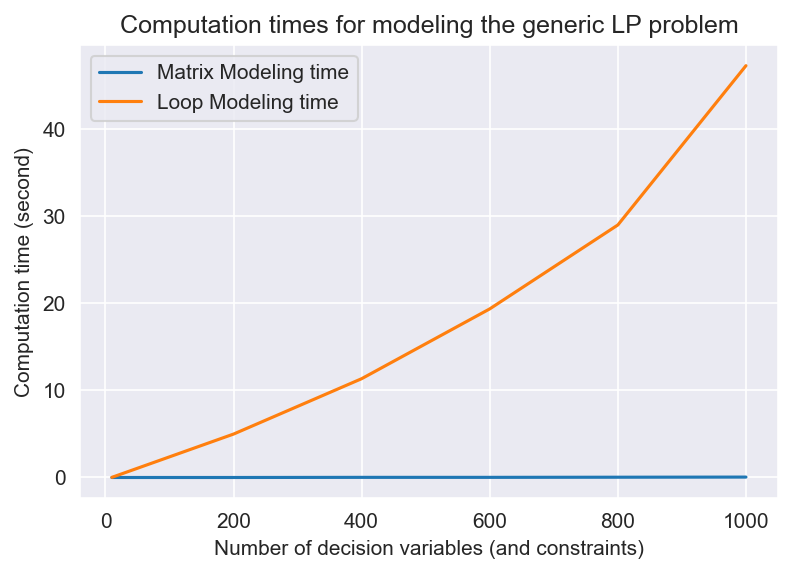

In [12]:
# plot computation times
plot_model_times(problem_size, computation_model)

Incredible, isn't it?!

Now before you get too exited, you should know that despite great computational gains on certain problems, matrix modeling in Gurobi has its own limitations. You can read more about it (and watch some videos) [here](https://www.gurobi.com/resource/gurobi-python-interface-matrix-friendly-modeling-techniques/).

### Exercise

If you are familiar with Python, you might know that list comprehensions are generally faster than loops. Try to come up with your own computational experiment to compare the modeling time using list comprehensions with loop and matrix modeling. You can use all the functions above or develop your own code from scratch if you want to show off.

## Solution performance

You have become familiar with the (primal) simplex method and interior point method for solving LP problems with continous decision variables. In this section, we run some experiments to investigate their computation times on different LP problem types.

In oder to do that, first we need to define a few functions so that later we can repeat solving LP problems with different parameters and compare their computation times. Note that to create the problems, every we are generating random numbers, which introduce stochasticity to our results (due to the statistical variation among sequences of random numbers). Therefore, we repeat each experiment multiple times (use multiple replications) and evaluate averages and confidence intervals of computation times in each scenario.

In [13]:
def solve_lp(model, algorithm_code):

    # to record execution time
    begin_time = datetime.now()

    # tell model which algorithm to use to solve
    model.Params.Method = algorithm_code

    # Optimize model
    model.optimize()

    # computation time
    computation_time = (datetime.now() - begin_time).total_seconds()

    return computation_time

In [14]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

def plot_solve_times(n_variables, computation_times):

    algorithms = {0: 'Primal simplex', 1: 'Interior point'}

    # create a data frame to store results
    computation_data = pd.DataFrame(columns=['Problem size', 'Algorithm', 'Replication', 'Computation time'])

    # iterate through results and store them in teh dataframe in a format that is easy to plot
    for rep in range(np.shape(computation_times)[0]):
        for size in range(np.shape(computation_times)[1]):
            for alg in range(np.shape(computation_times)[2]):
                row = {'Problem size': n_variables[size],
                       'Algorithm': algorithms[alg],
                       'Replication': rep + 1,
                       'Computation time': computation_times[rep, size, alg]}

                computation_data = computation_data.append(row, ignore_index=True)

    # make plots
    ax = sns.lineplot(data=computation_data, x="Problem size", y="Computation time", hue="Algorithm")
    ax.set_title('Computation times for solving the generic LP problem')

In [15]:
def compare_solution_times(n, m, n_replications, sparsity):

    # solution methods to use (primal simplex: 0, interior point: 2)
    algorithm = [0, 2]

    # to store computation times
    computation_solve = np.zeros((n_replications, len(n), len(algorithm)))

    # run and record time
    for i in range(len(n)):

        for r in range(n_replications):

            # prepare input data for the model
            a, b, c = model_input_lp(n[i], m[i], sparsity)

            # construct the model (we already know matrix is faster, so we just use it instead of loop)
            model, _ = model_construct_lp_matrix(a, b, c)

            # solve the model once with each algorithm and record computation times
            for j in range(len(algorithm)):
                computation_solve[r, i, j] = solve_lp(model, algorithm[j])
                model.reset()

    return computation_solve

Now that we have all the functions we need, let's compare some scenarios. Recall that $n$ and $m$ represent the number of decision variables and the number of constraints, respectively. Here we define a list of values for each parameter as well as the number of times for the scenario to be replicated (to check averages and confidence intervals). The following cell runs each scenario (defined by a combination of $n$ and $m$ values, e.g., scenario 1: $n=100$ and $m=100$) 50 times (with 50 variations of randomly generated coefficients, $A$, $b$ and $c$) and plots the results with confidence intervals (shadows in teh figure). Problem size is $n+m$.

If you want to run the scripts yourselves, be aware that some cells might take a bit long to execute since we replicate the experiments many times. If you want the cells to run faster, you can reduce replication numbers (n_replications). But (as you should know by now) lower number of replications means larger standard deviation and wider confidence intervals, which means less conclusive results.

### $n=m$, Integer coefficients, Small numbers

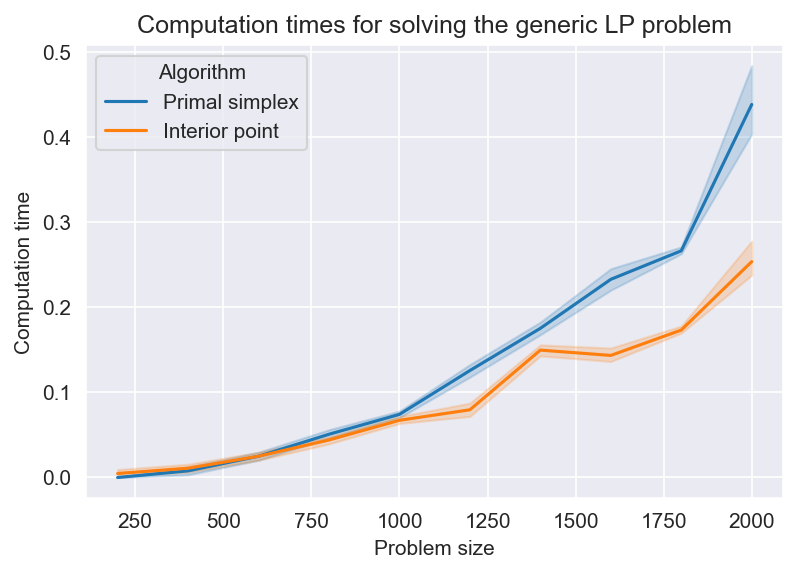

In [16]:
# lists of number of decision variables (n) and constraints (m) for experimentation
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n = [item * 100 for item in numbers]
m = [item * 100 for item in numbers]
sparsity = 0.05
# number of replications
n_replications = 10

computation_times = compare_solution_times(n, m, n_replications, sparsity)
plot_solve_times(np.sum([n, m], axis=0), computation_times)

As you can see, for very small problems, simplex method is more efficient but as the problem size grows, interior point starts to catch on. So let's check some larger problems to see what happens.

### $n=m$, Integer coefficients, Large numbers

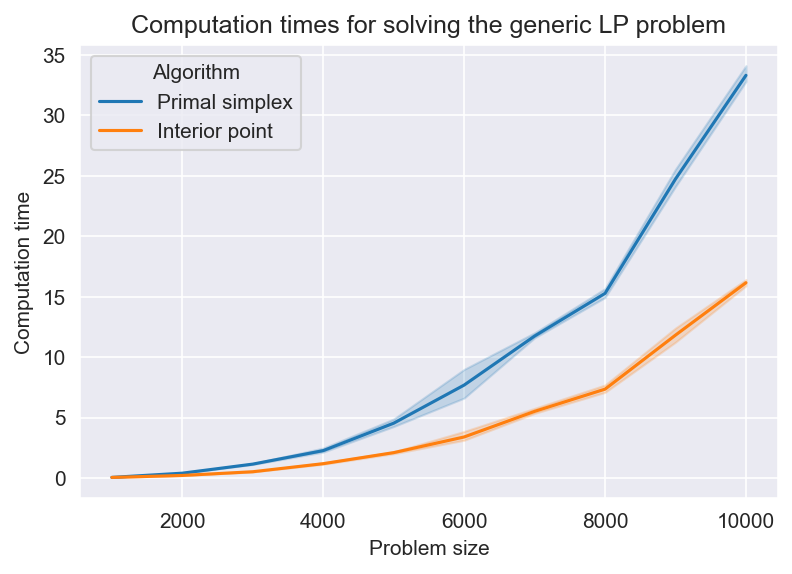

In [17]:
# larger numbers
n = [item * 500 for item in numbers]
m = [item * 500 for item in numbers]
n_replications = 5

computation_times = compare_solution_times(n, m, n_replications, sparsity)
plot_solve_times(np.sum([n, m], axis=0), computation_times)

Seems like for larger problems, interior point is slightly faster. Although the difference might seem very small and insignificant, keep in mind that in other types of optimization problems (e.g., mix-integer programming and bi-level problems) you might need to solve the LP problem many times (sometimes hundreds of thousands of times) as part of the overall solution method. Moreover, there are practical problems in real life with a few hundred thousand decision variables. So any improvement in performance matters.

In the last two examples, number of decision variables and the number of constrains were equal. Often that is not the case in practice. Now let's try some different combinations of $n$ and $m$ values to see how that impacts computation times.

### $n<<m$, Integer coefficients, Large numbers

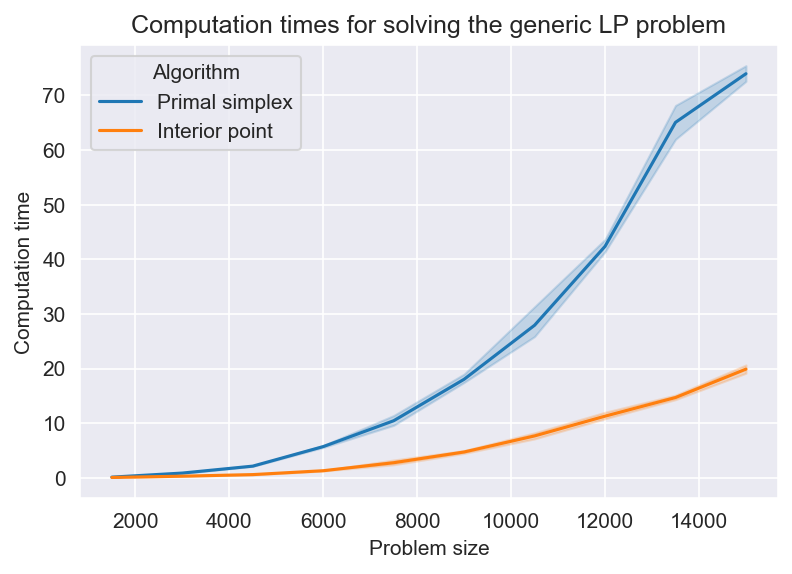

In [18]:

n = [item * 500 for item in numbers]
m = [item * 1000 for item in numbers]
n_replications = 5

# generate, model, solve the models, and compare computation times
computation_times = compare_solution_times(n, m, n_replications, sparsity)
# visualize computation times
plot_solve_times(np.sum([n, m], axis=0), computation_times)

### $n>>m$, Integer coefficients, Large numbers

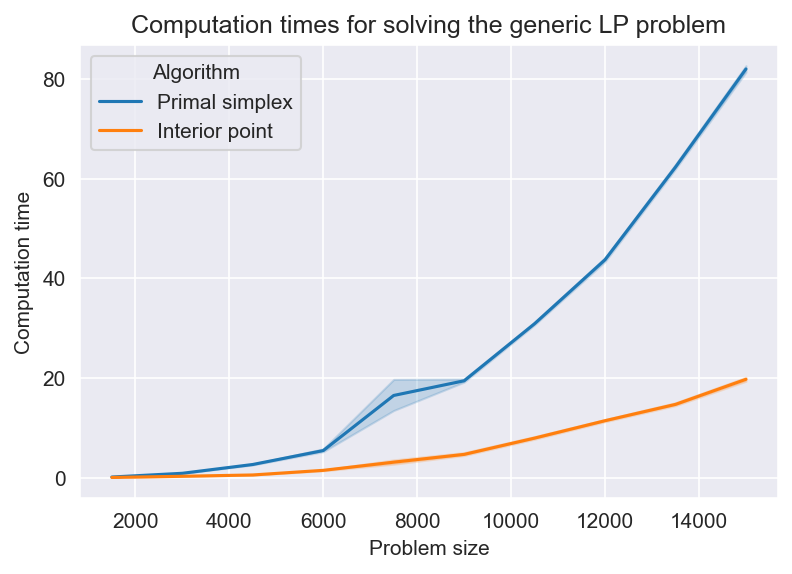

In [19]:

n = [item * 1000 for item in numbers]
m = [item * 500 for item in numbers]
n_replications = 5

# generate, model, solve the models, and compare computation times
computation_times = compare_solution_times(n, m, n_replications, sparsity)
# visualize computation times
plot_solve_times(np.sum([n, m], axis=0), computation_times)

So far we have been using small integers as coefficients. Now let's try to use large floats as coefficients to see if that changes computation times. Remember interior point method is a numerical method, so we expect it to be sensitive to numbers and potential numerical issues.

In order to assess the effects of large float coefficients on computation times, we need to change the function that generates random coefficients first.

In [20]:
def model_input_lp(m, n, sparsity):

    np.random.seed(seed=1)
    c = np.random.uniform(1000, 5000, n)
    a = np.random.uniform(1000, 5000, [m, n])
    b = np.random.uniform(1000, 5000, m)

    # set some elements of A matrix to zero
    for column in range(n):
        zero_indices = np.random.choice(range(m), int(m*(1-sparsity)), replace=False)
        a[zero_indices, column] = 0

    return a, b, c

Now we can just repeat the same scripts and see the results with large float coefficients.

### $n=m$, Float coefficients, Small numbers

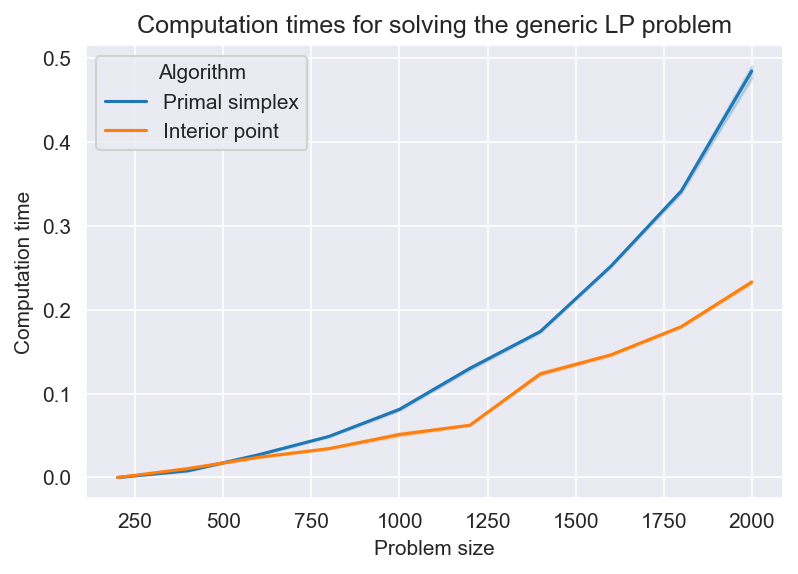

In [21]:

n = [item * 100 for item in numbers]
m = [item * 100 for item in numbers]
n_replications = 5

computation_times = compare_solution_times(n, m, n_replications, sparsity)
plot_solve_times(np.sum([n, m], axis=0), computation_times)

This is similar to the same scenario with small integer coefficients. However, computation times for both algorithms are higher with large float coefficients.

### $n=m$, Float coefficients, Large numbers

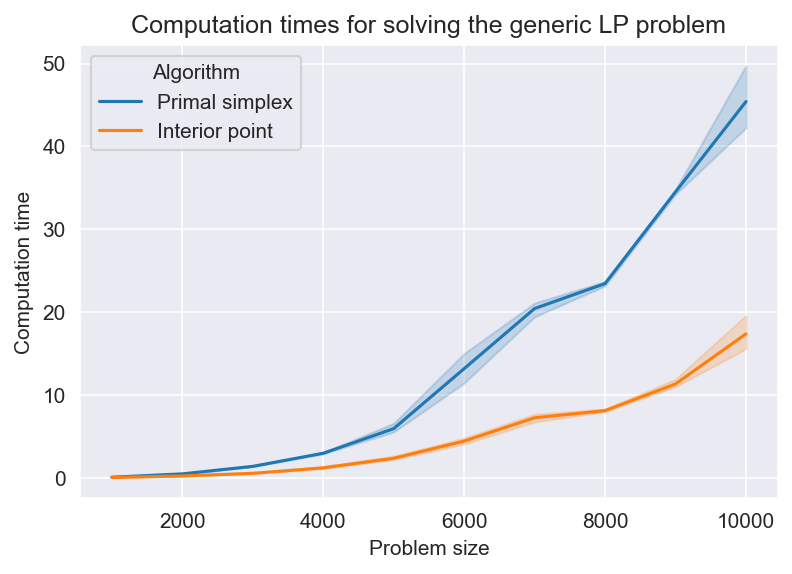

In [22]:
# larger numbers
n = [item * 500 for item in numbers]
m = [item * 500 for item in numbers]
n_replications = 5

computation_times = compare_solution_times(n, m, n_replications, sparsity)
plot_solve_times(np.sum([n, m], axis=0), computation_times)

### $n<<m$, Float coefficients, Large numbers

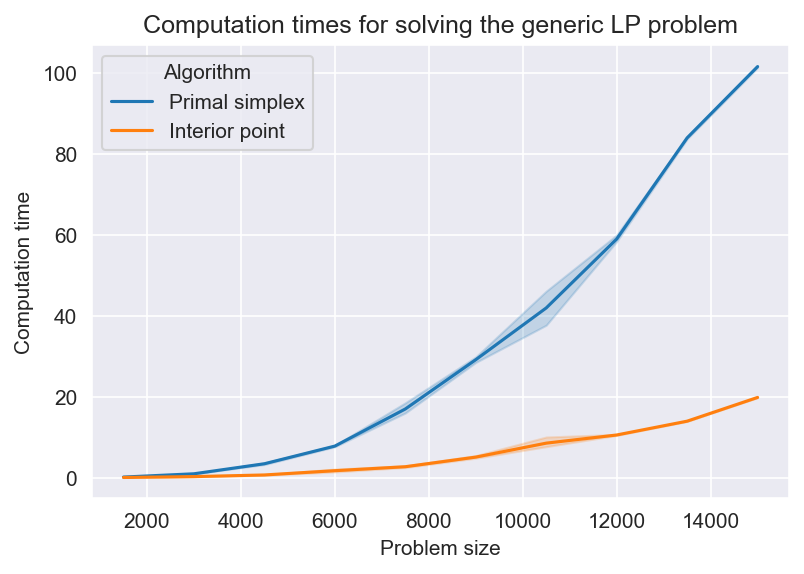

In [23]:

n = [item * 500 for item in numbers]
m = [item * 1000 for item in numbers]
n_replications = 5

# generate, model, solve the models, and compare computation times
computation_times = compare_solution_times(n, m, n_replications, sparsity)
# visualize computation times
plot_solve_times(np.sum([n, m], axis=0), computation_times)

### $n>>m$, Float coefficients, Large numbers

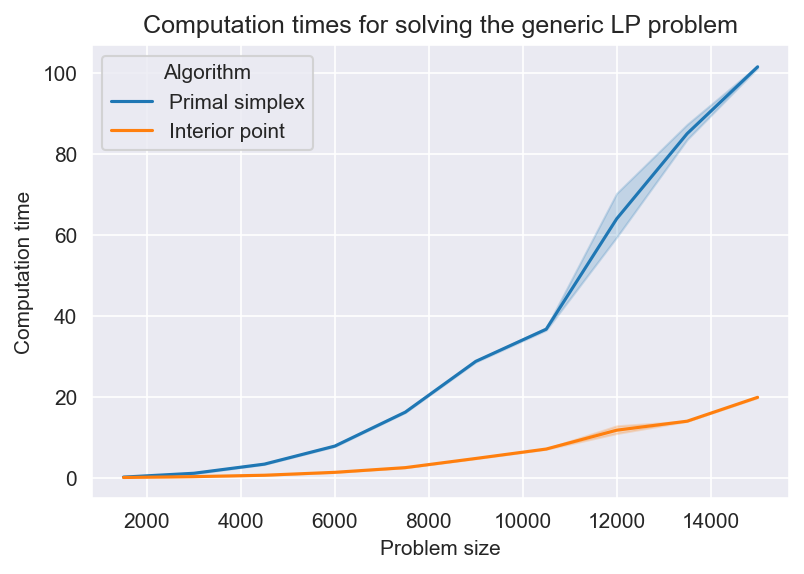

In [24]:

n = [item * 500 for item in numbers]
m = [item * 1000 for item in numbers]
n_replications = 5

# generate, model, solve the models, and compare computation times
computation_times = compare_solution_times(n, m, n_replications, sparsity)
# visualize computation times
plot_solve_times(np.sum([n, m], axis=0), computation_times)



Now let's change the sparsity parameter (percentage of matrix $A$ elements that are zero) and see if that makes a difference.

### $n=m$, Float coefficients, Small numbers, Sparsity = 0.5

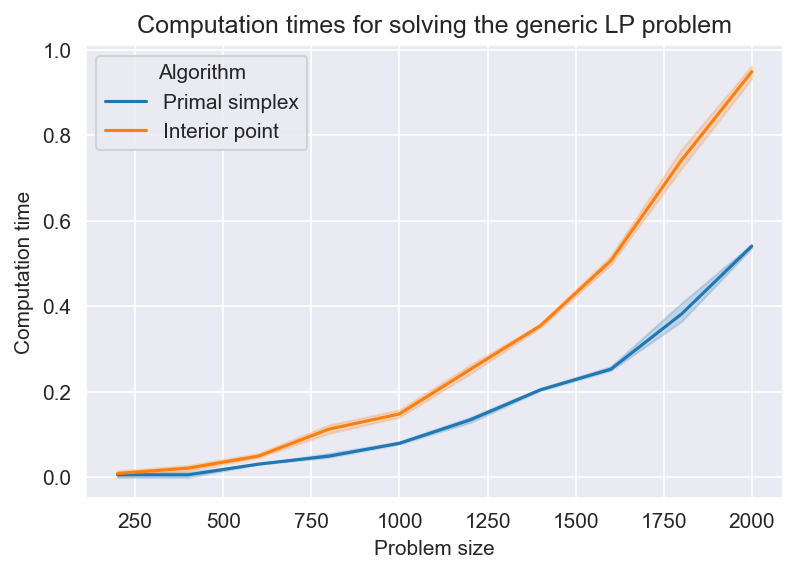

In [25]:
n = [item * 100 for item in numbers]
m = [item * 100 for item in numbers]
n_replications = 5
sparsity = 0.5

computation_times = compare_solution_times(n, m, n_replications, sparsity)
plot_solve_times(np.sum([n, m], axis=0), computation_times)

As you can see there are many factors that affect the LP solution algorithm performance, and we have not even considered all relevant factors here. So after these experiments, what criteria would you consider while selecting the best algorithm to solve your problem?

## Exercise

Play around with different values of the sparsity parameter and see if it affects the results. Based on the outcome, would you consider sparsity of the matrix $A$ a factor in determining the best performing algorithm?